# Amazon Deep Learning Container

* Container Images List [link](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)
* pytorch training: `763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.5.1-gpu-py36-cu101-ubuntu16.04`

# Download the pretrained model

In [3]:
gfid_yolov5s = '1R5T6rIyy3lLwgFXNms8whc-387H0tMQO'
fp_out = './container/local_test/test_dir/input/data/weights/yolov5s.pt'

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={gfid_yolov5s}' -O {fp_out}

--2020-07-22 08:11:36--  https://docs.google.com/uc?export=download&id=1R5T6rIyy3lLwgFXNms8whc-387H0tMQO
Resolving docs.google.com (docs.google.com)... 216.58.217.46, 2607:f8b0:400a:804::200e
Connecting to docs.google.com (docs.google.com)|216.58.217.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j4l363omp1qbevuc8ss649k4s1geos62/1595405475000/18003229793517042864/*/1R5T6rIyy3lLwgFXNms8whc-387H0tMQO?e=download [following]
--2020-07-22 08:11:37--  https://doc-0c-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j4l363omp1qbevuc8ss649k4s1geos62/1595405475000/18003229793517042864/*/1R5T6rIyy3lLwgFXNms8whc-387H0tMQO?e=download
Resolving doc-0c-a4-docs.googleusercontent.com (doc-0c-a4-docs.googleusercontent.com)... 172.217.3.193, 2607:f8b0:400a:808::2001
Connecting to doc-0c-a4-docs.googleusercontent.com (doc-0c-a4-docs.googleus

# Build container and run local test in terminal

* open new terminal

```
bash
cd /home/ec2-user/SageMaker/myAWSStudyBlog/yolov5-onnx-sm/3-yolov5-sm-container
./build-and-push.sh yolov5
```

# Run the local serv test container

Following the commands:
```
cd /home/ec2-user/SageMaker/myAWSStudyBlog/yolov5-onnx-sm/3-yolov5-sm-container/container/local_test
predict_local.sh yolov5
```

You will see the output at `test_dir/input/data/images/inference/output/`

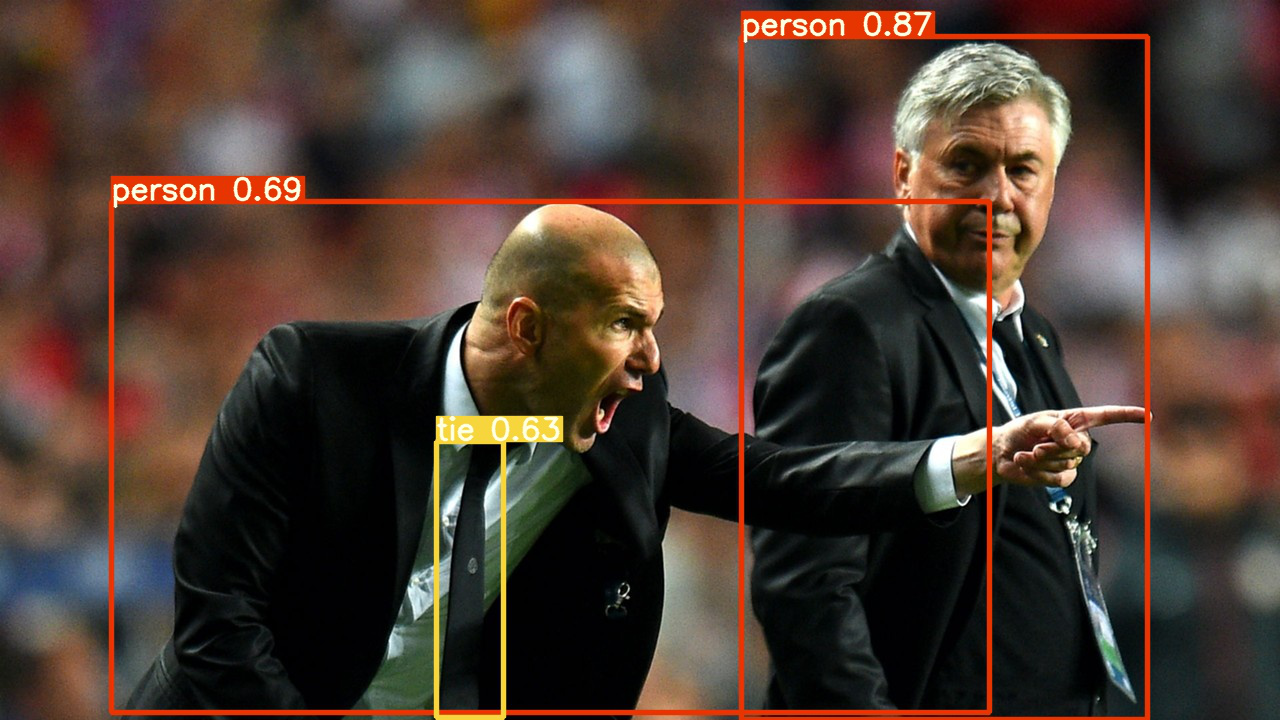

In [6]:
from PIL import Image

fp_img_out = './container/local_test/test_dir/input/data/images/inference/output/zidane.jpg'
img = Image.open(fp_img_out)
display(img)

# Train on SageMaker Host

In [ ]:
# push test_data into s3 bucket
import boto3
region = boto3.session.Session().region_name
# bucket = 'beyoung-sm-yolo5'
!aws s3api create-bucket --bucket {bucket} --create-bucket-configuration LocationConstraint={region}
!aws s3 cp --recursive container/local_test/test_dir/ s3://{bucket}

In [2]:
# ECR URI
account=boto3.client('sts').get_caller_identity().get('Account')
repositoryUri="{}.dkr.ecr.{}.amazonaws.com/yolov5".format(account, region)
repositoryUri

'476271697919.dkr.ecr.us-west-2.amazonaws.com/yolov5'

In [11]:
from datetime import datetime
now = datetime.now()
job_name = 'yolov4-' + now.strftime("%Y-%m-%d-%H-%M-%S")
job_name

'yolov4-2020-07-22-10-41-15'

In [10]:
# cfg  images weights labels
cfg='s3://{}/input/data/cfg/'.format(bucket)
images='s3://{}/input/data/images/'.format(bucket)
weights='s3://{}/input/data/weights/'.format(bucket)
labels='s3://{}/input/data/labels/'.format(bucket)
outpath='s3://{}/results/'.format(bucket)

In [8]:
import sagemaker
from sagemaker import get_execution_role
role = get_execution_role()
sm = boto3.client('sagemaker')

In [12]:
response = sm.create_training_job(
      TrainingJobName=job_name,
      AlgorithmSpecification={
          'TrainingImage': repositoryUri,
          'TrainingInputMode': 'File',
      },
      RoleArn=role,
      InputDataConfig=[
          {
              'ChannelName': 'cfg',
              'DataSource': {
                  'S3DataSource': {
                      'S3DataType': 'S3Prefix',
                      'S3Uri': cfg,
                      'S3DataDistributionType': 'FullyReplicated',
                  },
              },
              'InputMode': 'File'
          },
          {
              'ChannelName': 'images',
              'DataSource': {
                  'S3DataSource': {
                      'S3DataType': 'S3Prefix',                      
                      'S3Uri': images,
                      'S3DataDistributionType': 'FullyReplicated',
                  },
              },
              'InputMode': 'File'
          },
          {
              'ChannelName': 'labels',
              'DataSource': {
                  'S3DataSource': {
                      'S3DataType': 'S3Prefix',                      
                      'S3Uri': labels,
                      'S3DataDistributionType': 'FullyReplicated',
                  },
              },
              'InputMode': 'File'
          },
          {
              'ChannelName': 'weights',
              'DataSource': {
                  'S3DataSource': {
                      'S3DataType': 'S3Prefix',                      
                      'S3Uri': weights,
                      'S3DataDistributionType': 'FullyReplicated',
                  },
              },
              'InputMode': 'File'
          }
      ],
      OutputDataConfig={
          'S3OutputPath': outpath
      },
      ResourceConfig={
          'InstanceType': 'ml.p3.2xlarge',
          'InstanceCount': 1,
          'VolumeSizeInGB': 10,
      },
      StoppingCondition={
        'MaxRuntimeInSeconds': 60*60*5,
      }
  )
response

{'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:476271697919:training-job/yolov4-2020-07-22-10-41-15',
 'ResponseMetadata': {'RequestId': '62c926a9-3bb1-4b69-a553-d2a966c8531b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '62c926a9-3bb1-4b69-a553-d2a966c8531b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '101',
   'date': 'Wed, 22 Jul 2020 10:41:21 GMT'},
  'RetryAttempts': 0}}

## Reference and working notes

#### harmless error about hostname

* checkout the issue143 [link](https://github.com/aws/sagemaker-pytorch-training-toolkit/issues/143)

In [ ]:
docker run -v $(pwd)/test_dir:/opt/ml -it --rm yolov5 bash
nvidia-docker run -v $(pwd)/test_dir:/opt/ml --rm ${image} train

In [ ]:
python /opt/yolov5/train.py --img 640 --batch 16 --epochs 5 --data /opt/ml/input/data/cfg/coco128.yaml \
--cfg /opt/ml/input/data/cfg/yolov5s.yaml --weights /opt/ml/input/data/weights/yolov5s.pt

In [ ]:
## log directory, use tensorboard
tb_writer = SummaryWriter(log_dir=increment_dir('runs/exp', opt.name))

def increment_dir(dir, comment=''):
    # Increments a directory runs/exp1 --> runs/exp2_comment
    n = 0  # number
    dir = str(Path(dir))  # os-agnostic
    d = sorted(glob.glob(dir + '*'))  # directories
    if len(d):
        n = max([int(x[len(dir):x.find('_') if '_' in x else None]) for x in d]) + 1  # increment
    return dir + str(n) + ('_' + comment if comment else '')